PPO Using VAE

# VAE classes

https://github.com/AntixK/PyTorch-VAE/blob/master/models/vanilla_vae.py

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import torch.optim as optim


class VAE(nn.Module):
# Use Linear instead of convs

    def __init__(self,
                 in_channels: int,
                 latent_dim: int,
                 hidden_dims = None,
                 **kwargs) -> None:
        super(VAE, self).__init__()

        self.latent_dim = latent_dim
        out_channels = in_channels

        modules = []
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512]

        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Linear(in_channels, h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1], latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1], latent_dim)


        # Build Decoder
        modules = []

        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1])

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.Linear(hidden_dims[i], hidden_dims[i+1]),
                    nn.LeakyReLU())
            )



        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.Linear(hidden_dims[-1],hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Linear(hidden_dims[-1],out_channels),
                            nn.Tanh())

    def encode(self, input):
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]

    def decode(self, z):
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        result = self.decoder_input(z)
        #result = result.view(-1, 512, 2, 2)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def reparameterize(self, mu, logvar):
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input, **kwargs):
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return  self.decode(z), input, mu, log_var

    def state_dim_reduction(self, state):
        mu, log_var = self.encode(state)
        z = self.reparameterize(mu, log_var)
        return z


    def loss_function(self, reconstruction, input, mu, log_var) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        recons = reconstruction
        input = input
        mu = mu
        log_var = log_var

        recons_loss =F.mse_loss(recons, input)

        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        loss = recons_loss + kld_loss
        return {'loss': loss, 'Reconstruction_Loss':recons_loss, 'KLD':-kld_loss}


In [2]:
import pandas as pd

class VaeManager():
  def __init__(self, vae_model, optimizer, obs_file, batch_size):
    self.vae_model = vae_model
    self.optimizer = optimizer
    self.obs_file = obs_file
    self.batch_size = batch_size

  def train_step(self, batch):
    reconstruction, input, mu, log_var = self.vae_model(batch)
    loss = self.vae_model.loss_function(reconstruction, input, mu, log_var)['loss']
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()
    return loss

  def train_with_file(self):
    #TODO
    df = pd.read_csv(self.fileNames[0])
    for index, row in df.iterrows():
      pass

  def state_dim_reduction(self, state):
    return self.vae_model.state_dim_reduction(state)


# PPO using VAE

In [3]:
# https://github.com/RPC2/PPO

In [4]:
import torch
import torch.nn as nn


class MlpPolicy(nn.Module):
    def __init__(self, action_size, input_size=4):
        super(MlpPolicy, self).__init__()
        self.action_size = action_size
        self.input_size = input_size
        self.fc1 = nn.Linear(self.input_size, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3_pi = nn.Linear(24, self.action_size)
        self.fc3_v = nn.Linear(24, 1)
        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=-1)

    def pi(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3_pi(x)
        return self.softmax(x)

    def v(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3_v(x)
        return x

In [5]:
class AgentConfig:
    # Learning
    gamma = 0.99
    plot_every = 10
    update_freq = 1
    k_epoch = 3
    learning_rate = 0.02
    lmbda = 0.95
    eps_clip = 0.2
    v_coef = 1
    entropy_coef = 0.01

    # Memory
    memory_size = 400

    train_cartpole = True

In [8]:
import torch
import gym
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Agent(AgentConfig):
    def __init__(self, env, observation_space):
        self.env = env
        self.action_size = self.env.action_space.n  # 2 for cartpole
        if self.train_cartpole:
            self.policy_network = MlpPolicy(action_size=self.action_size, input_size = observation_space).to(device)
        self.optimizer = optim.Adam(self.policy_network.parameters(), lr=self.learning_rate)
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=self.k_epoch,
                                                   gamma=0.999)
        self.loss = 0
        self.criterion = nn.MSELoss()
        self.memory = {
            'state': [], 'action': [], 'reward': [], 'next_state': [], 'action_prob': [], 'terminal': [], 'count': 0,
            'advantage': [], 'td_target': torch.tensor([], dtype=torch.float)
        }

    def new_random_game(self):
        self.env.reset()
        action = self.env.action_space.sample()
        screen, reward, terminal, info = self.env.step(action)
        return screen, reward, action, terminal

    def train(self, vae_manager, vae_fit, num_episodes):
        step = 0
        reward_history = []
        avg_reward = []
        solved = False

        # A new episode
        for episode in range (1,num_episodes+1):
            start_step = step
            episode += 1
            episode_length = 0

            # Get initial state
            state, reward, action, terminal = self.new_random_game()
            state_mem = state
            state = torch.tensor(state, dtype=torch.float, device=device)
            if not vae_fit: 
                with torch.no_grad():
                  state = state.unsqueeze(dim=0)
                  state = vae_manager.state_dim_reduction(state).squeeze()
                  state_mem = state.tolist()
            total_episode_reward = 1
            # A step in an episode
            while True:
                step += 1
                episode_length += 1

                # Choose action
                prob_a = self.policy_network.pi(state)
                action = torch.distributions.Categorical(prob_a).sample().item()

                # Act
                new_state, reward, terminal, _ = self.env.step(action)
                new_state_mem = new_state
                new_state = torch.tensor(new_state, dtype=torch.float, device=device)
                
                if not vae_fit: 
                    print("Actual state and VAE state:")
                    print(new_state_mem)
                    with torch.no_grad():
                      new_state = new_state.unsqueeze(dim=0)
                      new_state = vae_manager.state_dim_reduction(new_state).squeeze()
                      new_state_mem = new_state.tolist()
                    print(new_state_mem)
                
                

                reward = -1 if terminal else reward

                self.add_memory(state_mem, action, reward/10.0, new_state_mem, terminal, prob_a[action].item())
                state = new_state
                state_mem = new_state_mem
                total_episode_reward += reward

                if vae_fit and episode % vae_manager.batch_size == 0:
                    vae_manager.train_step(torch.tensor(self.memory['state'][-10:], dtype=torch.float, device=device))

                if terminal:
                    episode_length = step - start_step
                    reward_history.append(total_episode_reward)
                    avg_reward.append(sum(reward_history[-10:])/10.0)

                    self.finish_path(episode_length)
                    print('episode: %.2f, total step: %.2f, last_episode length: %.2f, last_episode_reward: %.2f, '
                              'loss: %.4f, lr: %.4f' % (episode, step, episode_length, total_episode_reward, self.loss,
                                                        self.scheduler.get_last_lr()[0]))
                    # if not vae_fit:
                    #     print('episode: %.2f, total step: %.2f, last_episode length: %.2f, last_episode_reward: %.2f, '
                    #           'loss: %.4f, lr: %.4f' % (episode, step, episode_length, total_episode_reward, self.loss,
                    #                                     self.scheduler.get_last_lr()[0]))
                    # else:
                    #     print(f'Fitted vae for episode {episode} of {num_episodes}.')  

                    self.env.reset()

                    break

            if episode % self.update_freq == 0:
                for _ in range(self.k_epoch):
                    self.update_network()

            if episode % self.plot_every == 0 and not vae_fit:
                plot_graph(reward_history, avg_reward)

        self.env.close()

    def update_network(self):
        # get ratio
        pi = self.policy_network.pi(torch.tensor(self.memory['state'], dtype=torch.float, device=device))
        new_probs_a = torch.gather(pi, 1, torch.tensor(self.memory['action'], device=device))
        old_probs_a = torch.tensor(self.memory['action_prob'], dtype=torch.float, device=device)
        ratio = torch.exp(torch.log(new_probs_a) - torch.log(old_probs_a))

        # surrogate loss
        surr1 = ratio * torch.tensor(self.memory['advantage'], dtype=torch.float, device=device)
        surr2 = torch.clamp(ratio, 1 - self.eps_clip, 1 + self.eps_clip) * torch.tensor(self.memory['advantage'], dtype=torch.float, device=device)
        pred_v = self.policy_network.v(torch.tensor(self.memory['state'], dtype=torch.float, device=device))
        v_loss = (0.5 * (pred_v - self.memory['td_target']).pow(2)).to('cpu')  # Huber loss
        entropy = torch.distributions.Categorical(pi).entropy()
        entropy = torch.tensor([[e] for e in entropy])
        self.loss = ((-torch.min(surr1, surr2)).to('cpu') + self.v_coef * v_loss - self.entropy_coef * entropy).mean()

        self.optimizer.zero_grad()
        self.loss.backward()
        self.optimizer.step()
        self.scheduler.step()

    def add_memory(self, s, a, r, next_s, t, prob):
        if self.memory['count'] < self.memory_size:
            self.memory['count'] += 1
        else:
            self.memory['state'] = self.memory['state'][1:]
            self.memory['action'] = self.memory['action'][1:]
            self.memory['reward'] = self.memory['reward'][1:]
            self.memory['next_state'] = self.memory['next_state'][1:]
            self.memory['terminal'] = self.memory['terminal'][1:]
            self.memory['action_prob'] = self.memory['action_prob'][1:]
            self.memory['advantage'] = self.memory['advantage'][1:]
            self.memory['td_target'] = self.memory['td_target'][1:]

        self.memory['state'].append(s)
        self.memory['action'].append([a])
        self.memory['reward'].append([r])
        self.memory['next_state'].append(next_s)
        self.memory['terminal'].append([1 - t])
        self.memory['action_prob'].append(prob)

    def finish_path(self, length):
        state = self.memory['state'][-length:]
        reward = self.memory['reward'][-length:]
        next_state = self.memory['next_state'][-length:]
        terminal = self.memory['terminal'][-length:]

        td_target = torch.tensor(reward, device=device) + \
                    self.gamma * self.policy_network.v(torch.tensor(next_state, dtype=torch.float,device=device)) * torch.tensor(terminal, device=device)
        delta = (td_target - self.policy_network.v(torch.tensor(state, dtype=torch.float,device=device))).to('cpu')
        delta = delta.detach().numpy()

        # get advantage
        advantages = []
        adv = 0.0
        for d in delta[::-1]:
            adv = self.gamma * self.lmbda * adv + d[0]
            advantages.append([adv])
        advantages.reverse()

        if self.memory['td_target'].shape == torch.Size([1, 0]):
            self.memory['td_target'] = td_target.data
        else:
            self.memory['td_target'] = torch.cat((self.memory['td_target'].to(device), td_target.data), dim=0)
        self.memory['advantage'] += advantages


def plot_graph(reward_history, avg_reward):
    df = pd.DataFrame({'x': range(len(reward_history)), 'Reward': reward_history, 'Average': avg_reward})
    plt.style.use('seaborn-darkgrid')
    palette = plt.get_cmap('Set1')

    plt.plot(df['x'], df['Reward'], marker='', color=palette(1), linewidth=0.8, alpha=0.9, label='Reward')
    # plt.plot(df['x'], df['Average'], marker='', color='tomato', linewidth=1, alpha=0.9, label='Average')

    # plt.legend(loc='upper left')
    plt.title("CartPole", fontsize=14)
    plt.xlabel("episode", fontsize=12)
    plt.ylabel("score", fontsize=12)

    plt.savefig('score.png')

Streaming output truncated to the last 5000 lines.
[-0.05534183 -0.16102216  0.04829729  0.34829994]
[1.084306240081787, -1.6218127012252808, 0.20776309072971344, -1.0549991130828857]
Actual state and VAE state:
[-0.05856228 -0.35679658  0.05526329  0.65581303]
[-0.2973373830318451, 0.2215840220451355, -0.1224096491932869, -0.9079618453979492]
Actual state and VAE state:
[-0.06569821 -0.16248578  0.06837955  0.38103092]
[0.7776307463645935, 0.5502427220344543, 1.6328192949295044, 0.15578080713748932]
Actual state and VAE state:
[-0.06894792  0.03160194  0.07600017  0.11066763]
[0.19400665163993835, 1.20937979221344, 1.766383409500122, -1.25806725025177]
Actual state and VAE state:
[-0.06831588  0.22555723  0.07821352 -0.15710293]
[-0.9535239934921265, 0.5762162804603577, 0.13388249278068542, -0.093185655772686]
Actual state and VAE state:
[-0.06380474  0.02940765  0.07507147  0.15919329]
[0.04584794119000435, 0.12576977908611298, -1.381883144378662, 0.44814246892929077]
Actual state an

KeyboardInterrupt: ignored

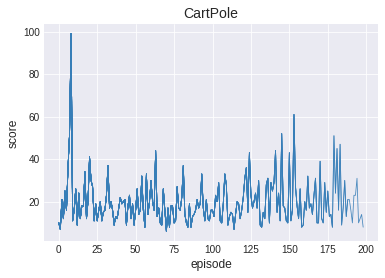

In [10]:
environment = gym.make('CartPole-v0')
observation_space = environment.observation_space.shape[0]

#Hyperparameters
latent_space = 4 # Feature space after VAE transform
vae_lr = 0.0001
vae_batch_size = 10

existingFile = "" #"drive/MyDrive/Thesis/Code/RL_PCA/feature_data.csv" # Possible existing file name containing observations for VAE fitting

vae_model = VAE(in_channels = observation_space, latent_dim = latent_space).to(device)
vae_optimizer = optim.Adam(params=vae_model.parameters(), lr=vae_lr)
vae_manager = VaeManager(vae_model, vae_optimizer, existingFile, vae_batch_size)

#Fit PCA by getting demo trajectories
if existingFile is None or existingFile == "":
    print("Demo Trajectories for fitting VAE")
    num_episodes = 300
    agent = Agent(environment, observation_space)
    agent.train(vae_manager, vae_fit = True, num_episodes = num_episodes)
else:
    vae_manager.train_with_file()

#Run actual Episodes
print("Actual trajectories")
num_episodes = 250
agent = Agent(environment, latent_space)
agent.train(vae_manager, vae_fit = False, num_episodes = num_episodes)